In [3]:
import pickle
from connections.mysql_connector import MySQL_Connector
from models.topic_modeling import Topic_Modeling
from connections.neo4j_connector import Neo4j_Connector
import os
from datetime import datetime
from gensim import corpora, models, similarities
from models.graph_generator import Graph_Generator
from models.tuple_extractor import Tuple_Extractor
from acessos import read, get_conn, persistir_uma_linha, persistir_multiplas_linhas, replace_df
import pandas as pd
import re
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.parsing.preprocessing import strip_punctuation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import re
from spacy.matcher import PhraseMatcher
from tqdm.auto import tqdm  # for notebooks
from models.youtube_extractor import Youtube_Extractor 

import credentials

In [5]:
nlp = spacy.load("pt_core_news_lg")

connector = MySQL_Connector("conn_orfeu")
conn = connector.return_conn("influencer_br")

neo4j_client = Neo4j_Connector(credentials.neo4j_uri, credentials.neo4j_user, credentials.neo4j_password)
graph_generator = Graph_Generator(neo4j_client)

tuple_extractor = Tuple_Extractor()

youtube_extractor = Youtube_Extractor()

In [3]:
def gerar_tuplas(texto):
    tuple_extractor.extrair_tupla(texto)
    df_tuplas = tuple_extractor.get_ultimas_tuplas_geradas()
    
    return df_tuplas

def extrair_ners(texto):
    df_ner = graph_generator.extrair_ner(texto)
    if df_ner.empty:
        return []   
    return df_ner['nome'].tolist()

def substituir_regex(texto, regex, subs=""):
    result = re.sub(regex, subs, texto, 0, re.MULTILINE)
    return result

def pre_processar(texto):
    regex = r"\[(.*?)\]" #TAGS 
    texto = substituir_regex(texto, regex, subs="")

    regex = r"\{(.*?)\}" #Chaves
    texto = substituir_regex(texto, regex, subs="")

    regex = r"[ ]{2,}" #Multiplos espçacos 
    texto = substituir_regex(texto, regex, subs=" ")

    texto = substituir_regex(texto, "\n", subs=". ") #Trantando pula linhas
    return texto

def contar_tokens(texto):
    doc = nlp(texto)
    num_token = 0
    for token in doc:
        if token.pos_ != "SPACE":
            num_token = num_token + 1
    return num_token

In [17]:
# texto = "É nós papai, Fisk, patrocina a gente aí..."
texto = '''
sobre o nosso mundo buscou o apoio de a globo experimento ja é uma de as maiores marcas de o nosso mundo de suplementação
'''
df_tupla = gerar_tuplas(texto)
print(df_tupla.shape)
df_tupla[['arg1', 'rel','arg2']]

 -> Salvando texto no input.txt
  -> Extraindo Tuplas...
Pronto :D
(5, 4)


,arg1,rel,arg2
0,o apoio de a globo,é uma,de as maiores marcas de o nosso mundo
1,o apoio de a globo,é uma,de as maiores marcas de o nosso mundo de suple...
2,o apoio de a globo,é uma,de as maiores marcas de suplementação
3,o apoio de a globo,experimento,ja
4,o apoio de a globo,é,uma de as maiores marcas de o nosso mundo


In [40]:
extrair_ners(texto)

,nome,label
0,Rico,LOC


### Análise:
#### Palavras chaves pesquisadas:
#### "Publicidade",  "Parceria paga", "Conteúdo patrocinado", "Apoio", "Oferecimento", "Patrocínio"

In [5]:
df_videos_candidatos = pd.read_excel(open('C:/Users/jpsan/Desktop/Projeto Tuplas Patrocinadas.xlsx', 'rb'), 
                                    sheet_name='Multiplas KeyWords',
                                    engine='openpyxl')
#df_videos_candidatos = df_videos_candidatos.loc[df_videos_candidatos['total_keywords'] >= 1] #filtrando videos que somente possuem as palavras chaves selecionadas

df_videos_candidatos['texto_pre_processado'] = df_videos_candidatos.apply(lambda x: pre_processar(x['transcription_pt']), axis=1)  #preprocessando o texto
df_videos_candidatos['transcription_tokens'] = df_videos_candidatos.apply(lambda x: contar_tokens(x['transcription_pt']), axis=1)  #contando o número de tokens
df_videos_candidatos.head()

df_videos_candidatos.to_excel("Projeto Tuplas Patrocinadas.xlsx", sheet_name='Dados Processados', engine='openpyxl')  

In [20]:
df_videos_candidatos = df_videos_candidatos.loc[df_videos_candidatos['transcription_type'] == "manual"] #Buscando transc manuais 
df_videos_candidatos.head()

,video_id,transcription_pt,transcription_type,texto_pre_processado
26,-HCHKLky7U8,[vinheta de abertura] Sejam bem-vindos ao Ner...,manual,Sejam bem-vindos ao Nerdologia! Eu sou o Átil...
42,-T_s_QWbOys,O canal do Melhores Destinos acaba de\ncomple...,manual,O canal do Melhores Destinos acaba de. comple...
45,-UWjGFxeIO0,Como eu me tornaria milionário em\nseis meses...,manual,Como eu me tornaria milionário em. seis meses...
52,-Ye-InMhfeQ,Oi gente! Eu tô aqui em Brasília com a\nequip...,manual,Oi gente! Eu tô aqui em Brasília com a. equip...
105,0uybJcDqGMM,Hoje eu vou mostrar pra vocês uns dos origami...,manual,Hoje eu vou mostrar pra vocês uns dos origami...


In [76]:

phrase_matcher = PhraseMatcher(nlp.vocab)
phrases = ["publicidade", "parceria paga", "conteúdo patrocinado", "apoio", "oferecimento", "patrocínio"]
patterns = [nlp(text) for text in phrases]
phrase_matcher.add('Patrocinado', None, *patterns)


In [96]:
dict_sentencas = {
                    "video_id":[],
                    "sentenca":[]
                 }
lista_sentencas_completa = []
lista_videos_completa = []

for row in tqdm(df_videos_candidatos.iterrows(), total=df_videos_candidatos.shape[0]):
    video_id = row[1]["video_id"]
    texto = row[1]["texto_pre_processado"]
    lista_sentencas = []

    doc = nlp(texto)

    for sent in doc.sents:
        for match_id, start, end in phrase_matcher(nlp(sent.text)):
            if nlp.vocab.strings[match_id] in ["Patrocinado"]:
                lista_sentencas.append(sent.text)
    
    if len(lista_sentencas) > 0:
        lista_videos = [video_id for i in lista_sentencas]
        lista_sentencas_completa.extend(lista_sentencas)
        lista_videos_completa.extend(lista_videos)

dict_sentencas["video_id"] = lista_videos_completa
dict_sentencas["sentenca"] = lista_sentencas_completa

df_sentencas = pd.DataFrame.from_dict(dict_sentencas)

df_sentencas['ners'] = df_sentencas.apply(lambda x: extrair_ners(x['sentenca']), axis=1)
df_sentencas['possui_ner'] = df_sentencas.apply(lambda x: 'sim' if len(x['ners']) > 1 else 'nao', axis=1)
df_sentencas.head()

100%|██████████| 137/137 [04:20<00:00,  1.90s/it]


,video_id,sentenca,ners,possui_ner
0,-HCHKLky7U8,Esse Nerdologia foi um oferecimento da NerdSto...,"[Nerdologia, NerdStore, Jovem Nerd, NerdOffice...",sim
1,-T_s_QWbOys,promoções de passagens aéreas do Brasil e em n...,"[Brasil, Youtube]",sim
2,-T_s_QWbOys,o apoio de cabeça é ajustável e usando os cont...,[],nao
3,-T_s_QWbOys,possível reclinar ajustar o apoio para os pés ...,[],nao
4,-UWjGFxeIO0,"Eu monetizaria com publicidade, não seria mone...",[],nao


In [98]:
df_sentencas.to_excel("df_sentencas.xlsx", sheet_name='Sentenças', engine='openpyxl')  


In [93]:
df_sentencas.head()

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,202
video_id,-HCHKLky7U8,-T_s_QWbOys,-T_s_QWbOys,-T_s_QWbOys,-UWjGFxeIO0,-Ye-InMhfeQ,0uybJcDqGMM,0uybJcDqGMM,0uybJcDqGMM,15ERwoOzPLk,...,YabTFq2aZfE,yHgVcDZumjw,yHgVcDZumjw,YHqC_qBOd0c,z71O5cHTOvM,Zd3jWFpw3NE,ZJCBM1SZ-FY,ZJCBM1SZ-FY,zkowgEg9zh4,ZQO72bWyXRw
sentenca,Esse Nerdologia foi um oferecimento da NerdSto...,promoções de passagens aéreas do Brasil e em n...,o apoio de cabeça é ajustável e usando os cont...,possível reclinar ajustar o apoio para os pés ...,"Eu monetizaria com publicidade, não seria mone...",moradoras que tomou para si essa ideia e const...,Hoje eu vou mostrar pra vocês uns dos origami...,Hoje eu vou mostrar pra vocês uns dos origami...,"Inclusive, exatamente agora eu to gravando o v...",Daí a revolução já tá lá com um apoio.,...,Esse Nerdologia foi um oferecimento da NERDSTORE!,"quase desconhecidas da política, o MBL consegu...",apoio e pela esperança de um monte de gente ap...,"eu tou aqui cursando publicidade né, daí que c...","Esse Nerdologia é um oferecimento de ""Pelando""...",esse nerdologia foi o. oferecimento da nerdsto...,Um agradecimento ao Tulio Baars e ao Pedro Loo...,"Esse Nerdologia é um oferecimento de ""Assassin...",Se você não quiser que os potinhos se moviment...,"Um oferecimento ""Marinex"",."


## Extração das Tuplas

In [7]:
df_sentencas = pd.read_excel(open('C:/Users/jpsan/Desktop/Projeto Tuplas Patrocinadas.xlsx', 'rb'), 
                                    sheet_name='Sentenças Ner',
                                    engine='openpyxl')
df_sentencas = df_sentencas.loc[df_sentencas['patrocinio_confirmado']=="sim"]
df_sentencas.head()

,video_id,sentenca_id,sentenca,ners,possui_ner,patrocinio_confirmado,Ana
0,-HCHKLky7U8,1,Esse Nerdologia foi um oferecimento da NerdSto...,"['Nerdologia', 'NerdStore', 'Jovem Nerd', 'Ner...",sim,sim,Sim
14,4gZr0XYY3eU,15,esse episódio foi um oferecimento da nerdstore...,"['nerdstore', 'protocólo bluehand']",sim,sim,Sim
16,4_TU5fI-zdQ,17,Esse Nerdologia é um oferecimento da Xiaomi Co...,"['Nerdologia', 'Xiaomi Considerada']",sim,sim,Sim
26,8hU7f1cf7iA,27,Esse Nerdologia foi um oferecimento de Assassin's,"['Nerdologia', 'Assassin']",sim,sim,Sim
42,AsQZByAQbm4,43,Esse Nerdologia foi oferecimento da NerdStore ...,"['Nerdologia', 'NerdStore']",sim,sim,Sim


In [8]:
df_tuplas = pd.DataFrame(columns=['video_id', 'sentenca_id','arg1', 'rel','arg2'])

for row in tqdm(df_sentencas.iterrows(), total=df_sentencas.shape[0]):
    sentenca = row[1]['sentenca']
    video_id = row[1]['video_id']
    sentenca_id = row[1]['sentenca_id']

    df_aux = gerar_tuplas(sentenca)[['arg1', 'rel','arg2']]
    df_aux['sentenca_id'] = sentenca_id 
    df_aux['video_id'] = video_id 

    df_tuplas = df_tuplas.append(df_aux)

print(df_tuplas.shape)
df_tuplas.head()

  0%|          | 0/51 [00:00<?, ?it/s] -> Salvando texto no input.txt
  -> Extraindo Tuplas...
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
  2%|▏         | 1/51 [00:16<13:53, 16.67s/it]Pronto :D
 -> Salvando texto no input.txt
  -> Extraindo Tuplas...
  4%|▍         | 2/51 [00:35<14:01, 17.18s/it]Pronto :D
 -> Salvando texto no input.txt
  -> Extraindo Tuplas...
  6%|▌         | 3/51 [00:57<15:05, 18.86s/it]Pronto :D
 -> Salvando texto no input.txt
  -> Extraindo Tuplas...
  8%|▊         | 4/51 [01:18<15:09, 19.35s/it]Pronto :D
 -> Salvando texto no input.txt
  -> Extraindo Tuplas...
 10%|▉         | 5/51 [01:38<15:05, 19.68s/it]Pronto :D
 -> Salvando texto no input.txt
  -> Ext

,arg1,arg2,rel,sentenca_id,video_id
0,Esse Nerdologia,de a NerdStore,foi um oferecimento,1,-HCHKLky7U8
1,Esse Nerdologia,de a NerdStore que tem um monte de produtos ex...,foi um oferecimento,1,-HCHKLky7U8
2,Esse Nerdologia,de a NerdStore que tem um monte de produtos ex...,foi um oferecimento,1,-HCHKLky7U8
3,Esse Nerdologia,que tem um monte de produtos exclusivos de o J...,foi um oferecimento,1,-HCHKLky7U8
4,Esse Nerdologia,é mesmo,foi um oferecimento,1,-HCHKLky7U8


In [9]:
df_tuplas.to_excel("df_tuplas.xlsx", sheet_name='tuplas', engine='openpyxl')  

Média de tokens nas sentenças patrocinadas: 32.254901960784316
Desvio padrão da média de tokens nas sentenças patrocinadas: 46.40467353069296


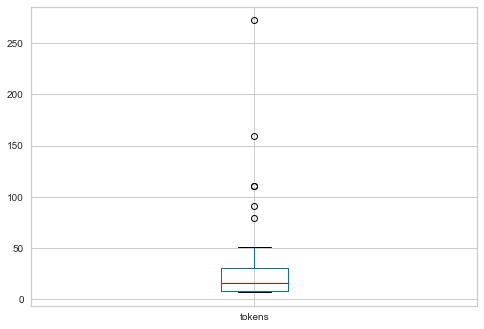

In [15]:
#Extraindo média das sentenças

df_sentencas['tokens'] = df_sentencas.apply(lambda x: contar_tokens(x['sentenca']), axis=1)

print("Média de tokens nas sentenças patrocinadas: {}".format(df_sentencas['tokens'].mean()))
print("Desvio padrão da média de tokens nas sentenças patrocinadas: {}".format(df_sentencas['tokens'].std()))

df_sentencas.boxplot(column='tokens', return_type='axes')

## Processando ASR 

In [91]:

def calcular_intervalo_sentenca(start, token_count, doc_length):
    inicio =  start - token_count if start - token_count >= 0 else 0
    fim = start + token_count if start + token_count <= doc_length else doc_length
    
    return (inicio, fim)


def gerar_pseudo_sentenca(texto, media):

    doc = nlp(texto)
    token_count = round(media/2) 

    lista_sentencas = []

    for match_id, start, end in phrase_matcher(nlp(doc.text)):
            if nlp.vocab.strings[match_id] in ["Patrocinado"]:
                intervalo_tokens = calcular_intervalo_sentenca(start, token_count, len(doc))
            
                sentenca = ""
                for index in range(intervalo_tokens[0], intervalo_tokens[1]):
                    sentenca = sentenca + " " + doc[index].text
                lista_sentencas.append(sentenca)

    return lista_sentencas

In [111]:
df_asr = pd.read_excel(open('C:/Users/jpsan/Desktop/Projeto Tuplas Patrocinadas.xlsx', 'rb'), 
                                    sheet_name='Multiplas KeyWords',
                                    engine='openpyxl')
df_asr.drop('transcription_pt', axis=1, inplace=True)

df_asr = df_asr.loc[df_asr['Freq Palavras']>=1]
df_asr = df_asr.loc[df_asr['transcription_type']=="automatica"]

df_asr.head()

,video_id,texto_pre_processado,transcription_type,transcription_tokens,publicidade,parceria_paga,conteúdo_patrocinado,apoio,oferecimento,patrocinio,Freq Palavras
0,--UzUusjJ9A,a leitora linda tudo bem agora a gente olha l...,automatica,3013.0,Nao,Nao,Nao,Sim,Nao,Nao,1
1,-02_-_rVVpI,e aí pessoal tudo bem que quem fala é o edu g...,automatica,5880.0,Nao,Nao,Nao,Sim,Nao,Nao,1
3,-3KMafr1a88,sejam bem vindos a metodologia da história me...,automatica,1361.0,Nao,Nao,Nao,Sim,Nao,Nao,1
4,-4Dby3uboVI,sejam bem vindos a metodologia decisória meu ...,automatica,1356.0,Nao,Nao,Nao,Sim,Nao,Nao,1
5,-4TeNI3ipc8,o Olá bebidas tudo bom com vocês justamente v...,automatica,2501.0,Nao,Nao,Nao,Sim,Nao,Nao,1


In [112]:
media = 32

df_pseudo_sentecas = pd.DataFrame(columns=['sentenca','video_id'])
for row in tqdm(df_asr.iterrows(), total=df_asr.shape[0]):
    dict_dados = {}

    texto = row[1]['texto_pre_processado']
    video_id = row[1]['video_id']

    lista_sentencas = gerar_pseudo_sentenca(texto, media)
    lista_videos = [video_id for i in lista_sentencas]

    dict_dados['sentenca'] = lista_sentencas
    dict_dados['video_id'] = lista_videos

    df_aux = pd.DataFrame.from_dict(dict_dados)
    df_pseudo_sentecas = df_pseudo_sentecas.append(df_aux)
   
print(df_pseudo_sentecas.shape)
df_pseudo_sentecas.head()

100%|██████████| 3255/3255 [42:43<00:00,  1.27it/s](4767, 2)



,sentenca,video_id
0,o domínio é o goleiro não tem maneira essa mi...,--UzUusjJ9A
0,sobrevive sobrevivem a gente vem fica aqui me...,-02_-_rVVpI
0,não vão aceitar a presença do governo bolivia...,-3KMafr1a88
0,e nobres indianos descontentes com as condiçõ...,-4Dby3uboVI
1,dos portugueses e retomar o território será e...,-4Dby3uboVI


In [113]:
df_pseudo_sentecas['ners'] = df_pseudo_sentecas.apply(lambda x: extrair_ners(x['sentenca']), axis=1)
df_pseudo_sentecas['possui_ner'] = df_pseudo_sentecas.apply(lambda x: 'sim' if len(x['ners']) > 1 else 'nao', axis=1)

In [116]:
print(df_pseudo_sentecas.shape)
df_pseudo_sentecas.head()

df_pseudo_sentecas.to_excel("pseudo_sents.xlsx", sheet_name='pseudo', engine='openpyxl')  

(4767, 4)


In [119]:



texto = '''
transporte de veículos pesados pelo nosso país esse vídeo não poderia ter sido feito sem o apoio e o patrocínio da mwf painéis e cases customizados para produtos e projetos eletrônicos a mwf
'''

media = 32
gerar_pseudo_sentenca(texto, media)

lista_sentencas = gerar_pseudo_sentenca(texto, media)
lista_sentencas
# gerar_tuplas(lista_sentencas[0])
df_tuplas = gerar_tuplas(texto)[['arg1','rel','arg2']]


 -> Salvando texto no input.txt
  -> Extraindo Tuplas...
Pronto :D


In [4]:
df_pseudo_sents = pd.read_excel(open('C:/Users/jpsan/Desktop/Projeto Tuplas Patrocinadas.xlsx', 'rb'), 
                                    sheet_name='Pseudo Sentenças',
                                    engine='openpyxl')

df_tuplas = pd.DataFrame(columns=['video_id', 'sentenca_id','arg1', 'rel','arg2'])

for row in tqdm(df_pseudo_sents.iterrows(), total=df_pseudo_sents.shape[0]):
    sentenca = row[1]['sentenca']
    video_id = row[1]['video_id']
    sentenca_id = row[1]['sentenca_id']

    df_aux = gerar_tuplas(sentenca)[['arg1', 'rel','arg2']]
    df_aux['sentenca_id'] = sentenca_id 
    df_aux['video_id'] = video_id 

    df_tuplas = df_tuplas.append(df_aux)

print(df_tuplas.shape)
df_tuplas.head()

  0%|          | 0/4767 [00:00<?, ?it/s]


NameError: name 'gerar_tuplas' is not defined

In [12]:
len(df_tuplas['video_id'].unique())

672

In [13]:
df_tuplas.shape

(9206, 5)

# Algoritmo seletor de Tuplas

In [4]:
phrase_matcher = PhraseMatcher(nlp.vocab)
phrases = ["publicidade", "parceria paga", "conteúdo patrocinado", "apoio", "oferecimento", "patrocínio"]
patterns = [nlp(text) for text in phrases]
phrase_matcher.add('Patrocinado', None, *patterns)

def possui_key_word(texto):
    doc = nlp(texto)

    for match_id, start, end in phrase_matcher(doc):
        if nlp.vocab.strings[match_id] in ["Patrocinado"]:
            return "sim"
    return "não"

def possui_ner(texto):
    doc = nlp(texto)
    if len(doc.ents) != 0:
        print(doc.ents)
        return "sim"
    return "não" 

possui_ner("Camila tem um carro e um cachorro")
possui_key_word("Este vídeo é um oferecimento do Nerdologia")


(Camila,)


'sim'

In [5]:
df_tuplas_manuais = pd.read_excel(open('C:/Users/jpsan/Desktop/Projeto Tuplas Patrocinadas.xlsx', 'rb'), 
                                    sheet_name='Tuplas Asr')

df_tuplas_manuais['tupla_completa'] = df_tuplas_manuais.apply(lambda x: "{} {} {}".format(x['arg1'], x['rel'], x['arg2']), axis=1) 
df_tuplas_manuais['possui_ner'] = df_tuplas_manuais.apply(lambda x: possui_ner(x['tupla_completa']), axis=1) 
df_tuplas_manuais['possui_key_word'] = df_tuplas_manuais.apply(lambda x: possui_key_word(x['tupla_completa']), axis=1) 

df_tuplas_manuais.head()

en,)
(mtur,)
(mtur,)
(mtur en,)
(mtur en,)
(mtur,)
(mtur en,)
(mtur en,)
(santander,)
(santander,)
(santander, bradesco bradesco)
(santander,)
(bradesco bradesco,)
(galera   ,)
(galera   ,)
(galera   ,)
(lion   ,)
(lion   ,)
(lion   ,)
(lion   ,)
(lion   ,)
(lion   , like)
(lion   ,)
(lion   ,)
(galera,)
(galera,)
(galera,)
(galera,)
(psol, rio de janeiro)
(psol,)
(rio de janeiro,)
(rio de janeiro,)
(3d,)
(3d,)
(adamaris,)
(brasil,)
(damaris,)
(damaris,)
(brasil,)
(adamaris,)
(mesinha lateral,)
(bobeira   ,)
(bobeira, tube)
(bobeira, tube)
(bobeira   ,)
(bobeira   ,)
(eduardo né,)
(davi silva   davi,)
(davi silva   davi,)
(davi silva   davi,)
(davi silva   davi,)
(davi silva   davi,)
(sherry,)
(sherry, brian)
(brian,)
(sherry,)
(sherry, brian)
(brian   ,)
(brian   ,)
(zico   , johnson)
(zico   , johnson johnson)
(zico   , johnson)
(curso   ,)
(johnson,)
(johnson johnson,)
(johnson,)
(sine, roriz   )
(sine, roriz   )
(sine, roriz   )
(sine, roriz   )
(estácio parceirassa,)
(estácio parc

,arg1,arg2,rel,sentenca_id,video_id,tupla_completa,possui_ner,possui_key_word
0,o goleiro,bonito e esses apoio,deixou,1,--UzUusjJ9A,o goleiro deixou bonito e esses apoio,sim,sim
1,o goleiro,bonito e esses apoio tem não,deixou,1,--UzUusjJ9A,o goleiro deixou bonito e esses apoio tem não,sim,sim
2,o goleiro,bonito e esses apoio tem não maneira,deixou,1,--UzUusjJ9A,o goleiro deixou bonito e esses apoio tem nã...,sim,sim
3,o goleiro,bonito,deixou,1,--UzUusjJ9A,o goleiro deixou bonito,não,não
4,o goleiro,bonito tem não maneira,deixou,1,--UzUusjJ9A,o goleiro deixou bonito tem não maneira,sim,não


In [7]:
df_tuplas_patrocinio = df_tuplas_manuais.loc[(df_tuplas_manuais['possui_ner'] == 'sim') & (df_tuplas_manuais['possui_key_word'] == 'sim')]
df_tuplas_patrocinio.to_excel("tuplas_patrocinio.xlsx", sheet_name='patrocinio', engine='openpyxl')  


In [13]:
texto = "outros aparelhos olha   é uma publicidade personalizada e bruno você você aí en o chão e camisetinha vermelha imagina bruno você você "
possui_ner(texto)

(bruno, bruno)


'sim'

# Dados Canais 

In [49]:
connector = MySQL_Connector("conn_orfeu")
conn = connector.return_conn("influencer_br")

def get_dados_canais():
    query = '''
    SELECT 
	video_id, channel_name, video_title, 
    if( comment_count < 0, 0, comment_count ) comment_count,
    if( dislike_count < 0, 0, dislike_count ) dislike_count,
    if( view_count < 0, 0, view_count ) view_count,
    if( like_count < 0, 0, like_count ) like_count,
    polarity,
    subjectivity
    FROM 
	videos v
    INNER JOIN 
		video_transcriptions vt USING(video_id) 
	WHERE 
		transcription_type <> "Erro" 
    '''
    return read(conn, query)

df_videos = get_dados_canais()
df_videos.head()

,video_id,channel_name,video_title,comment_count,dislike_count,view_count,like_count,polarity,subjectivity
0,--3FrTHN9qw,Dany Martines,DIY SUPER FOFINHOS DE EMOJI ???? Apoiador de C...,1101.0,122.0,98284.0,10701.0,NaN,NaN
1,--CryguVEik,Mayra Cardi,BRIGADEIRO SAUDÁVEL - GordicesSaudáveis #7,101.0,22.0,34966.0,1842.0,NaN,NaN
2,--JOEggYBac,Danilo Gentili,VOLTAMOS SEGUNDA!,502.0,83.0,105649.0,9711.0,NaN,NaN
3,--K2l7qd7W0,Victor Sorrentino,CÉREBRO TURBINADO | Dr. Victor Sorrentino,112.0,94.0,84443.0,5912.0,NaN,NaN
4,--LvfeLT1Iw,Central de Fãs de Luisa Mell,Luisa Mell visita cachorra que foi explorada c...,86.0,6.0,11823.0,1367.0,0.319423,0.580064


In [50]:
df_videos.describe()

,comment_count,dislike_count,view_count,like_count,polarity,subjectivity
count,34535.000000,34535.000000,3.453500e+04,3.453500e+04,7393.000000,7393.000000
mean,1783.850760,840.220935,6.588850e+05,5.141716e+04,0.152116,0.489265
std,5204.997439,2886.268736,2.082346e+06,1.533354e+05,0.071831,0.058939
min,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.282813,0.000000
25%,170.000000,60.000000,5.725950e+04,4.688500e+03,0.107659,0.453171
50%,582.000000,197.000000,1.895160e+05,1.710600e+04,0.149704,0.491036
75%,1579.000000,604.000000,5.456515e+05,4.800450e+04,0.192269,0.525594
max,234624.000000,132490.000000,8.894125e+07,5.527981e+06,0.750000,0.861111


In [28]:
df_medias_canais = df_videos.groupby('channel_name').mean()
df_std_canais = df_videos.groupby('channel_name').std()

df_medias_canais.to_excel("df_medias.xlsx", sheet_name='medias', engine='openpyxl')  

In [86]:
lista_videos = [
        {
            "canal": 'Adrenaline',
            "video_id": '2Eixsi2O0Bw'
        },
        {
            "canal": "Be!Tech",
            "video_id": '2DSsa7QXIi4'
        },
        {   
            "canal": "Nerdologia",
            "video_id": '-HCHKLky7U8'
        },
        {
            "canal": "O Primo Rico",
            "video_id": "dJyJ77GkhBE"
        }
     ]


canal = "O Primo Rico"
video_id = "dJyJ77GkhBE" 

print("Médias:")
print(df_medias_canais.loc[canal])
print("****")
print("Desvios Padrões:")
print(df_std_canais.loc[canal])
df_videos.loc[df_videos['video_id'] == video_id]

Médias:
comment_count      1330.791667
dislike_count       563.808824
view_count       423913.102941
like_count        39888.838235
polarity              0.157225
subjectivity          0.463886
Name: O Primo Rico, dtype: float64
****
Desvios Padrões:
comment_count      2578.353779
dislike_count      1166.958700
view_count       589243.438961
like_count        50891.171550
polarity              0.069886
subjectivity          0.037697
Name: O Primo Rico, dtype: float64


,video_id,channel_name,video_title,comment_count,dislike_count,view_count,like_count,polarity,subjectivity
22388,dJyJ77GkhBE,O Primo Rico,O Guia BÁSICO para começar a INVESTIR com POUC...,2346.0,977.0,1681973.0,147871.0,NaN,NaN


In [85]:
texto = pre_processar('''  Speak cousins, how are you? Today's video is going to be very important because  I'll help those people who want to invest, whether it's investing better or giving their  first step in the investment world.  So we usually want to know where to invest  and we also want to know how to invest, but what solves all these problems  is exactly knowledge, right? So let's go to the video.  First of all, if you didn't already know Primo Rico's channel  be sure to click the subscribe button. Click there, click on the bell to receive the next notifications  and if you are part of this class, you are already part of the cousins ​​be sure to click  I didn't like it, because it helps the video reach a lot more people and it  it helps a lot to reach my goal here on the channel. My goal in today's video  is to give you a step by step of what you should or can do to invest  your money correctly. So let's start with the first one:  the first one is obvious and you may not even need to go through this one.  The first step is to get out of debt, but I'm not going to focus on that here in the video  because I made a video exactly telling you what you need to do to  get out of debt, so I'll leave the link here if you  want to address this issue in more depth,  but if you have no debt then you can move on to step 2.  What is step 2? It's a change of approach, because you have no debt  but we need to see our mindset too, because it is our mindset that  will produce money. It is not money that will generate a positive mindset  and the positive and correct investment mindset is to look at the  income, look at profitability as something solid, as something perennial.  We cannot look at profitability thinking about stratospheric yields  in the very short term, whoever invests like this or who thinks they are investing like this  usually has a very fast path, a very short path, usually  that person loses money and starts the cycle again, starts the cycle again.  So you have to be very careful and adjust your mindset,  you will have consistent gains in the medium to long term unfortunately, but this is the  correct mindset and once you know that's how it works now you  you have to understand what knowledge you need to start investing.  And when are you going to start investing which is your first priority: present or future?  Your first priority is the present, because look at this: if you don't  go through it you will not arrive in the future, if you do not climb the first, the second,  the third step you will not reach the fifth step for example, right? So  you need to look at the present. As we can have several unforeseen events now  we need to turn these unforeseen events into planned events,  the only certainty we have is that the unexpected is predictable.  Don't you know a lot of people who have been through unexpected wrenches?  A car crashed, someone got sick, that person was unemployed, had to spend more than  should or unwittingly spent more than it should.  Don't you know people like that? I know and not only know but I already  I went through unforeseen events. The difference is that people who  prepare for that moment they do not need to resort to money of  third parties, they don't need to borrow money, they have money to live  finance and how do we prepare  for that moment? We form our emergency fund or our  opportunity. What is the mechanics of this? Before thinking  in which application will I put my money I need to think about the strategy.  My applications will meet my need, my goal.  What is my first goal? I have six months of my monthly cost saved.  Six months of my monthly cost saved so if I have an expense, I don’t know  Caique speaks a monthly cost there  1,200 reais? So if I have a monthly cost of 1,200 reais  so it needs to be six times 1,200 reais, so I'm going to need 7,200 reais  saved, okay? Because? Because if any happen  problem i can at least live another six months with the same quality of  life I have, only if you are an entrepreneur, a self-employed professional  you have a much more unpredictable recipe, don't you? There are months that come a lot  money has a month that doesn’t come in and sometimes we spend a long time without  receive, so the cool thing is that we prepare  a little bit better so instead of having six months of  your monthly cost, the idea is that you have 12 months of your  monthly cost. So, if you have a cost of 1,200 reais  we are talking about 14,400 reais here, you would need to have this  value saved so that you can be more relaxed in the short term, but what  is that monthly cost? The monthly cost is as follows: if it happens  something unforeseen with you, you can keep eating what you eat, leaving  the way you go out, paying for your health plan, having the perks that  you have. You maintain your standard of living  during this period and this is step 1, it is no use thinking about step 2  before we go through step 1, right? Same example of the ladder: I will not  reach the second step if I don't go through the first one, even if I fly by,  but I went through it, so I need to do this. So beauty:  reach my first stage, then I'll think about the next step,  but which applications make sense for my first stage? Let's think  I need to be able to redeem my money at any time, right? I got to have  a very low risk here because it is a necessity money,  not money that will enrich me. Now if I have a high liquidity - liquidity is the  speed at which I turn my application into money -  if I have a low risk my profitability is unlikely to be much  high, because there is no such application. It would be like super asset of  investments, it doesn't exist. What applications  do they fit in? You have a number of applications:  you have the Selic treasure, you have a DI fund and you have a  Liquid CDB. These are the three main applications that  supply our need if you want to see me applying my  money in an application that serves as an emergency fund i will leave a  link here for you to watch. So, Thiago, I’m already here from my background  emergency, what's the next step? The next step is retirement because  the first priority is the short term and the other is the future. And the sad news is  that one percent of people retire with the same quality of life  so stop to think: out of 100 people you know, statistically one person  will retire with the same quality because they don't think about retirement  but how do you think about yours? to prepare for yours? for  make money work for you by then  so that when you arrive at that moment the money generates income  enough so that you can, if you want, stop working? Let's do the  next: Caique, how much would you like to receive per month to retire in the future?  7 thousand? Okay, so what are you going to do: you're going to get  a value, in the case of Caique of 7 thousand reais, and you will multiply this by 300.  Look how simple: 7 thousand reais times 300 will give 7, 14, 21. It will give 2,100,000 reais.  So who wants to retire earning 7 thousand reais a month can aim at  2,100,000 reais. Now how did I do this calculation? Well, I'm going  leave in the description to make it easier, because the idea here is not to get into that  math like that, but if you take the amount you want to receive per month and multiply  for 300 you will get a number that will get  get too close to reality, okay? If you had 2,100,000 today  you could retire receiving something close to 7 thousand reais  per month, so remember: first emergency fund objective, so it was 12 thousand  real? This is my number one goal.  what is the next goal? Retirement. What is my retirement goal?  2,100,000 reais. Okay, every month I’m going to apply to get there.  Now, you want to see a business, let's do a calculation here: Caique, tell me the following.  How old are you today?  How old do you want to stop working?  50? So you're saying that 26 years are left, is that it?  26 years. So there are 312 months left for Caique to retire.  So Caique wants to reach 2 million and 100. Caique, how much have you saved?  One thousand reais. Caique already has a thousand reais saved.  If Caique had an income of 1% per month here  Caique would need to invest 975 reais to retire at the age of 50.  Per month, right? You would need to live x a month. Now look how cool:  if you were to retire at the age of 60, you would have 36 years to get there.  36 years times 12 months.  Then it was easy.  For you to retire at 60 you would need 279 reais.  Easy, eh Caique? You just have to cut this pizza there that you eat.  Stop spending all your VR, right man? That you get there. Now beauty, in what you  going to invest your money? Because it is long term, what are the characteristics  long-term application? Simple: always look at three things, okay?  Profitability, risk and liquidity. What is the profitability you want?  You want the highest possible profitability because we are talking about the long term.  But for you to have a very high profitability you need to have a high or medium risk, because this is obvious.  There is no super asset in investments. Now, what is liquidity?  Liquidity is the speed that turns investments into cash.  Liquidity is also low, because look at this: you don't have to redeem the money.  Caique doesn't have to. He is 24 and wants to retire at 60 so this portion of the portfolio  his will be destined for the long run. He doesn't need to rescue now, okay?  Which applications fit this? Well, stocks, real estate funds,  debentures, funds and some social security also and IPCA treasury.  These are some of the applications that have long term characteristics  Sometimes you can set up a card here, diversify a little, study more the  background for you to understand a lot about some  of these markets that I told you about now and that you can feel more confident to  enter the debentures or real estate funds market, because I  I believe that the more knowledge you have the less fear you will have  and the better your decisions will be so sometimes you don't need to know  the entire market, but you can study what attracts you most within these options  that I passed you. And then every month you invest, you go  constituting your pension portfolio, your retirement portfolio and  it gets closer and closer to its goal.  Now what do you have to keep in mind? You have to keep in mind that: who is going to provide you with  best options for you to apply? Are you going to talk to your manager today the  will he tell you? Caique, what does your manager ask or say when  are you there with him drinking the most expensive coffee in history?  Not at all, for you it must be about 80% that I know. But don't you have consortia?  Some capitalizations?  No?  What happens? The bank will offer you the things  bank itself, you know? It is not that the bank is evil, it is that the bank is a company.  If you had a company, what would you like to do, would you like to make more money, wouldn't you?  That's how a company thinks and the employee of the company,  wouldn't you like him to think about the company? So you put an employee  you want him to hit goal, don't you? He's not an evil employee, he's hitting the goal, right?  Actually the error is here, the error is in our head, it's the people who are wrong isn't it  the person on the other side who is offering us a product that is not consistent  because we need to have knowledge to understand what is good and what is not  for us, so what do we want? We want freedom so instead of going to a bank  that will not offer you options from other banks, for example, you can go to a  broker. The broker will play a role in agglomerating almost all products  available in the financial market and with an account, a registration with a broker  you can access the product that gives you the best result, that makes the most sense for you.  You have freedom of choice and you can open an account with the brokerage  you want all of them are free, but the channel here has a partnership with  Rico broker, ok? So just click on the registration link  will have a registration link you open your registration is free and you already  can access an almost infinite list of investment products you  you can compare profitability, deadlines have options and there you are.  But there are some precautions that you need to take, because you are starting to invest  I have 100 reais and I want to start applying it well. I go there and open  an account with a broker. And when I'm going to invest in a broker  I have costs in some applications that I do.  Let's suppose that I am going to buy shares, I am going to buy one hundred reais from AmBev.  Every Brazilian likes beer so I'm going to talk about AmBev.  And then you paid Ted 10 reais from your bank to the brokerage and then  paid more brokerage fee. Let's say you paid 35 reais  in total of those costs. If you bought 100 reais and you paid 35  fee, are you saying you started your  operation, its investment life losing 35%.  35%, for you to return to that profitability you know how much you would need your  investment would yield? You would need AmBev to earn 70 percent, because imagine:  you have 10 reais. Your investment has dropped 50% how much do you have now? You have 5 reais.  For your 5 reais to become 10 your application now needs to yield 100%. You understand?  So you need to be very, very careful about the costs,  but obviously the cost that I told you about is usually much more  close to the reality of banks that charge exorbitant fees.  At brokerages, rates are usually lower. Some of them don't even pay a fee, for example  in Rico, which is a partner here in the channel, the brokerage fee to fund  real estate is 0. The direct treasure is 0, in short, income  fixed is 0 there are a lot of things, but then you can see it better on the site.  So I talked about a few things here: first, this transaction fee, a  brokerage usually makes your life easier and another fee, the Ted fee and this one is a  little harder to get away because the bank usually have a fee. Ted  is what charges you to transfer, but the fourth step for you to invest  especially if you are starting is you open an account with a digital bank  because digital banks don't usually charge Ted.  They don't usually charge this fee so I did a little simulation comparing what?  The investor has an account with a traditional bank and an account with a bank  that doesn't charge Ted, so I took into account that this  investor transfers money to the broker every month and invests there.  So what did I consider? I considered that the investor will initially invest a thousand  in both situations and then he will invest 100 reais every month in the Selic Treasury.  The person who has a bank account  traditional, in 10 years it has 15,956 reais.  And through a digital bank 18,444.  In 20 years 43,769. In 20 years 50,883.  In 30 years 95,000. In 30 years 111 thousand.  In other words, the impact of 15 reais of Ted's rate, which was what I considered, gave a  result of a difference of almost 16 thousand reais in the future. 15 reais from Ted. 16 thousand  in the future so look at the weight of that decision, right?  So this is what I wanted to pass on to you.  Shall we review? First step: get out of debt. I left a video explaining about it.  Second step: change the way you  think and structure an investment portfolio  Third step: open an account with a broker and fourth step: open an account with a digital bank.  I hope you enjoyed today's video.  I wait for you in our next, a hug and until then''')

youtube_extractor.process_sentiment(texto)


(0.11044173394173387, 0.39180704080704076)